In [1]:
import json
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas
import seaborn as sns

from asapdiscovery.ml.schema import TrainingPredictionTracker

%matplotlib inline

In [2]:
model_dir = Path("../trained_models/")
all_models = ["moonshot", "sars", "mers", "sars_pretrained", "mers_pretrained"]

pretraining_labs = [
    "Pretraining Run", "From Scratch", "From Scratch", "Pretrained", "Pretrained"
]
pretrain_lab_dict = dict(zip(all_models, pretraining_labs))

targets = ["Moonshot (SARS)", "SARS", "MERS", "SARS", "MERS"]
target_lab_dict = dict(zip(all_models, targets))

model_seeds = ["1", "2"]

tpt_dict = {}
for lab in all_models:
    print(lab, flush=True)
    run_id_path = model_dir / lab / "run_id"
    pred_tracker_path = model_dir / lab / run_id_path.read_text() / "pred_tracker.json"
    tpt_dict[(lab, "No Seed",)] = TrainingPredictionTracker(
        **json.loads(pred_tracker_path.read_text())
    )

    for seed in model_seeds:
        print(seed, flush=True)
        seed_path = model_dir / f"{lab}_multi_seed" / seed
        if not seed_path.exists():
            print(seed_path, "not found", flush=True)
            continue
        run_id_path = seed_path / "run_id"
        pred_tracker_path = seed_path / run_id_path.read_text() / "pred_tracker.json"
        tpt_dict[(lab, seed)] = TrainingPredictionTracker(
            **json.loads(pred_tracker_path.read_text())
        )

moonshot
1
2
sars
1
2
mers
1
2
sars_pretrained
1
../trained_models/sars_pretrained_multi_seed/1 not found
2
../trained_models/sars_pretrained_multi_seed/2 not found
mers_pretrained
1
../trained_models/mers_pretrained_multi_seed/1 not found
2
../trained_models/mers_pretrained_multi_seed/2 not found


In [3]:
def calc_mae(g):
    return np.mean(np.abs(g["pred"] - g["target"]))

epoch_plot_df = []
best_epoch_compound_df = []
mae_best_epoch_compound_df = []
for (lab, seed), pred_tracker in tpt_dict.items():
    # Use val loss to find epoch with the lowest loss
    df = pred_tracker.to_plot_df(agg_compounds=True, agg_losses=True)
    val_df = df.loc[df["split"] == "val", :]
    best_epoch = val_df.iloc[np.argmin(val_df["loss"]), :]["epoch"]
    # print(lab, best_epoch, flush=True)

    # DF with each compound's pred for each epoch
    df = pred_tracker.to_plot_df(agg_compounds=False, agg_losses=True)

    # MAE for each epoch
    mae_df = (
        df.groupby(["split", "epoch"])
        .apply(calc_mae)
        .reset_index(level=["split", "epoch"])
        .reset_index(drop=True)
        .rename(columns={0: "MAE"})
    )
    mae_df["model"] = lab
    mae_df["pretrained"] = [pretrain_lab_dict[lab] for lab in mae_df["model"]]
    mae_df["Train Target"] = [target_lab_dict[lab] for lab in mae_df["model"]]
    mae_df["Split"] = [s.title() for s in mae_df["split"]]
    mae_df["Seed"] = seed
    epoch_plot_df.append(mae_df)

    val_df = mae_df.loc[mae_df["split"] == "val", :]
    mae_best_epoch = val_df.iloc[np.argmin(val_df["MAE"]), :]["epoch"]
    print(lab, seed, best_epoch, mae_best_epoch, flush=True)

    df["model"] = lab
    df["pretrained"] = [pretrain_lab_dict[lab] for lab in df["model"]]
    df["Train Target"] = [target_lab_dict[lab] for lab in df["model"]]
    df["Split"] = [s.title() for s in df["split"]]
    df["Seed"] = seed

    best_loss_df = df.loc[df["epoch"] == best_epoch, :]
    best_epoch_compound_df.append(best_loss_df)

    best_mae_df = df.loc[df["epoch"] == mae_best_epoch, :]
    mae_best_epoch_compound_df.append(best_mae_df)

epoch_plot_df = pandas.concat(epoch_plot_df, axis=0, ignore_index=True)
best_epoch_compound_df = pandas.concat(
    best_epoch_compound_df, axis=0, ignore_index=True
)
mae_best_epoch_compound_df = pandas.concat(
    mae_best_epoch_compound_df, axis=0, ignore_index=True
)
display(epoch_plot_df)
display(best_epoch_compound_df)
display(mae_best_epoch_compound_df)

moonshot No Seed 1299 1198
moonshot 1 3260 1562
moonshot 2 1504 1184
sars No Seed 3379 3379
sars 1 3206 3193
sars 2 3465 3463
mers No Seed 1499 1380
mers 1 1172 1145
mers 2 1261 1240
sars_pretrained No Seed 3994 3994
mers_pretrained No Seed 424 102


,split,epoch,MAE,model,pretrained,Train Target,Split,Seed
0,train,0,5.238730,moonshot,Pretraining Run,Moonshot (SARS),Train,No Seed
1,train,1,5.106924,moonshot,Pretraining Run,Moonshot (SARS),Train,No Seed
2,train,2,4.975607,moonshot,Pretraining Run,Moonshot (SARS),Train,No Seed
3,train,3,4.844279,moonshot,Pretraining Run,Moonshot (SARS),Train,No Seed
4,train,4,4.712956,moonshot,Pretraining Run,Moonshot (SARS),Train,No Seed
...,...,...,...,...,...,...,...,...
91669,val,4594,0.516144,mers_pretrained,Pretrained,MERS,Val,No Seed
91670,val,4595,0.511875,mers_pretrained,Pretrained,MERS,Val,No Seed
91671,val,4596,0.514964,mers_pretrained,Pretrained,MERS,Val,No Seed
91672,val,4597,0.514545,mers_pretrained,Pretrained,MERS,Val,No Seed


,split,epoch,compound_id,pred,target,in_range,loss,model,pretrained,Train Target,Split,Seed
0,train,1299,AGN-NEW-891393a6-1,4.709246,5.18,0,0.221609,moonshot,Pretraining Run,Moonshot (SARS),Train,No Seed
1,train,1299,BAR-COM-4e090d3a-6,3.774561,4.45,0,0.456217,moonshot,Pretraining Run,Moonshot (SARS),Train,No Seed
2,train,1299,CHR-SOS-7098f804-10,4.797271,4.62,0,0.031425,moonshot,Pretraining Run,Moonshot (SARS),Train,No Seed
3,train,1299,CHR-SOS-7098f804-14,4.996757,4.41,0,0.344283,moonshot,Pretraining Run,Moonshot (SARS),Train,No Seed
4,train,1299,DAR-DIA-23aa0b97-20,4.470762,4.21,0,0.067997,moonshot,Pretraining Run,Moonshot (SARS),Train,No Seed
...,...,...,...,...,...,...,...,...,...,...,...,...
12849,val,424,ASAP-0031882,5.543948,5.27,0,0.075048,mers_pretrained,Pretrained,MERS,Val,No Seed
12850,val,424,ASAP-0031887,5.553069,5.11,0,0.196310,mers_pretrained,Pretrained,MERS,Val,No Seed
12851,val,424,ASAP-0031888,5.525776,5.24,0,0.081668,mers_pretrained,Pretrained,MERS,Val,No Seed
12852,val,424,ASAP-0031893,5.309647,5.26,0,0.002465,mers_pretrained,Pretrained,MERS,Val,No Seed


,split,epoch,compound_id,pred,target,in_range,loss,model,pretrained,Train Target,Split,Seed
0,train,1198,AGN-NEW-891393a6-1,4.721662,5.18,0,0.210074,moonshot,Pretraining Run,Moonshot (SARS),Train,No Seed
1,train,1198,BAR-COM-4e090d3a-6,3.858866,4.45,0,0.349439,moonshot,Pretraining Run,Moonshot (SARS),Train,No Seed
2,train,1198,CHR-SOS-7098f804-10,4.867540,4.62,0,0.061276,moonshot,Pretraining Run,Moonshot (SARS),Train,No Seed
3,train,1198,CHR-SOS-7098f804-14,5.023602,4.41,0,0.376508,moonshot,Pretraining Run,Moonshot (SARS),Train,No Seed
4,train,1198,DAR-DIA-23aa0b97-20,4.399993,4.21,0,0.036097,moonshot,Pretraining Run,Moonshot (SARS),Train,No Seed
...,...,...,...,...,...,...,...,...,...,...,...,...
12849,val,102,ASAP-0031882,5.563353,5.27,0,0.086056,mers_pretrained,Pretrained,MERS,Val,No Seed
12850,val,102,ASAP-0031887,5.574617,5.11,0,0.215869,mers_pretrained,Pretrained,MERS,Val,No Seed
12851,val,102,ASAP-0031888,5.414515,5.24,0,0.030456,mers_pretrained,Pretrained,MERS,Val,No Seed
12852,val,102,ASAP-0031893,5.217477,5.26,0,0.001808,mers_pretrained,Pretrained,MERS,Val,No Seed


In [18]:
pretraining_idx = epoch_plot_df["pretrained"] == "Pretraining Run"
from_scratch_idx = epoch_plot_df["pretrained"] == "From Scratch"
from_pretrained_idx = epoch_plot_df["pretrained"] == "Pretrained"

best_epoch_pretraining_idx = best_epoch_compound_df["pretrained"] == "Pretraining Run"
best_epoch_from_scratch_idx = best_epoch_compound_df["pretrained"] == "From Scratch"
best_epoch_from_pretrained_idx = best_epoch_compound_df["pretrained"] == "Pretrained"
mae_best_epoch_pretraining_idx = mae_best_epoch_compound_df["pretrained"] == "Pretraining Run"
mae_best_epoch_from_scratch_idx = mae_best_epoch_compound_df["pretrained"] == "From Scratch"
mae_best_epoch_from_pretrained_idx = mae_best_epoch_compound_df["pretrained"] == "Pretrained"

val_idx = best_epoch_compound_df["Split"] == "Val"
mae_val_idx = mae_best_epoch_compound_df["Split"] == "Val"

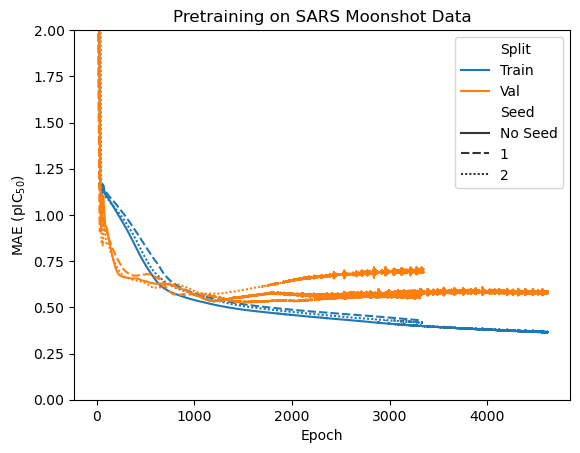

In [8]:
ax = sns.lineplot(
    epoch_plot_df.loc[pretraining_idx, :],
    x="epoch",
    y="MAE",
    style="Seed",
    style_order=["No Seed", "1", "2"],
    hue="Split",
    hue_order=["Train", "Val"],
    # dashes={"Train": "", "Val": (1, 4)},
    # facet_kws={"sharex": False},
    # kind="line",
)

ax.set(ylim=(0, 2))
ax.set_ylabel("MAE (pIC$_{50}$)")
ax.set_xlabel("Epoch")
ax.set_title("Pretraining on SARS Moonshot Data")

ax.get_figure().savefig("../figures/pretraining_loss_curves.png", dpi=200, bbox_inches="tight")

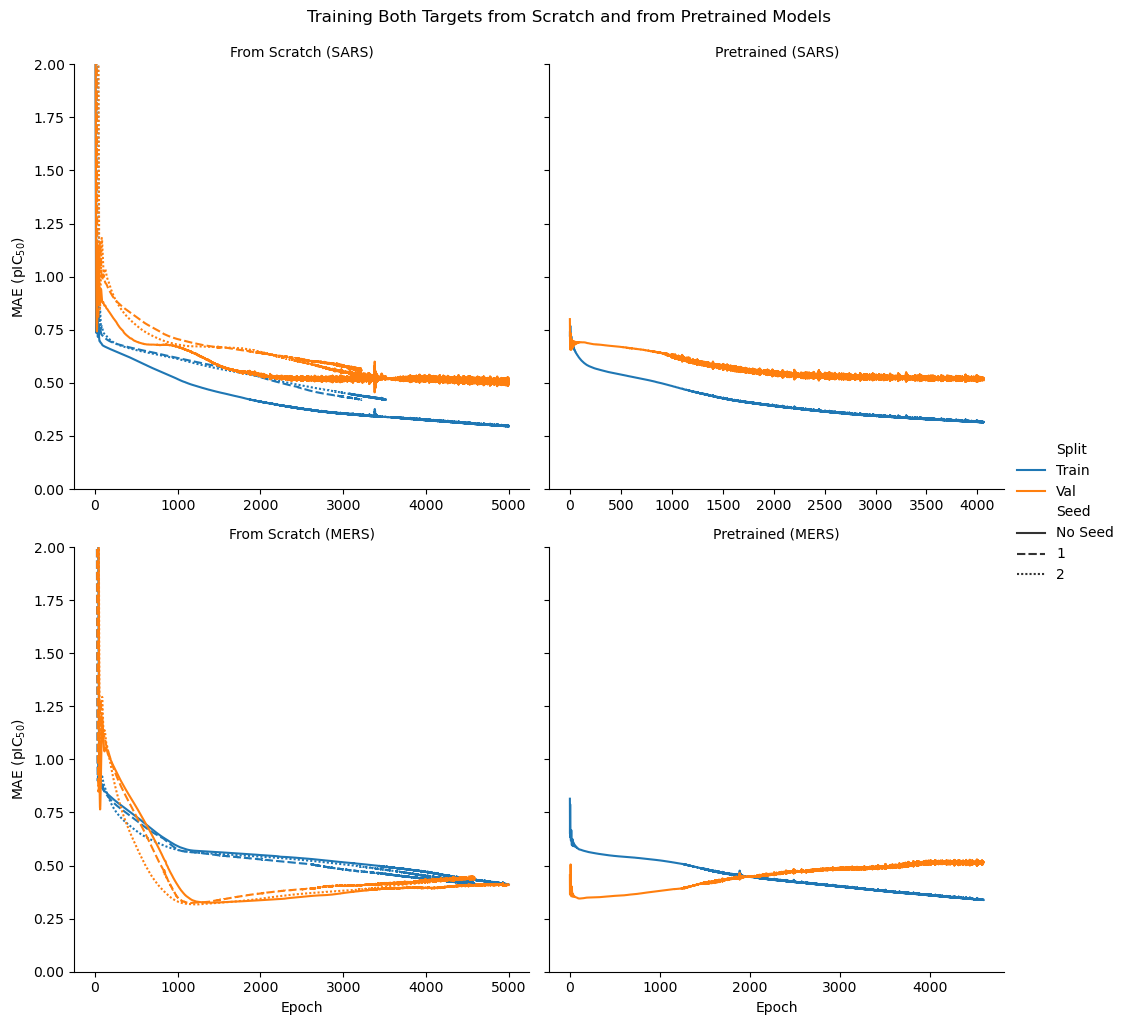

In [5]:
fg = sns.relplot(
    epoch_plot_df,
    x="epoch",
    y="MAE",
    row="Train Target",
    row_order=["SARS", "MERS"],
    col="pretrained",
    col_order=["From Scratch", "Pretrained"],
    style="Seed",
    style_order=["No Seed", "1", "2"],
    hue="Split",
    hue_order=["Train", "Val"],
    # dashes={"Train": "", "Val": (1, 4)},
    facet_kws={"sharex": False},
    kind="line",
)

fg.set(ylim=(0, 2))
fg.set_titles("{col_name} ({row_name})")
fg.set_axis_labels(y_var="MAE (pIC$_{50}$)", x_var="Epoch")
fg.figure.suptitle("Training Both Targets from Scratch and from Pretrained Models", y=1.02)

fg.savefig("../figures/training_loss_curves_both.png", dpi=200, bbox_inches="tight")

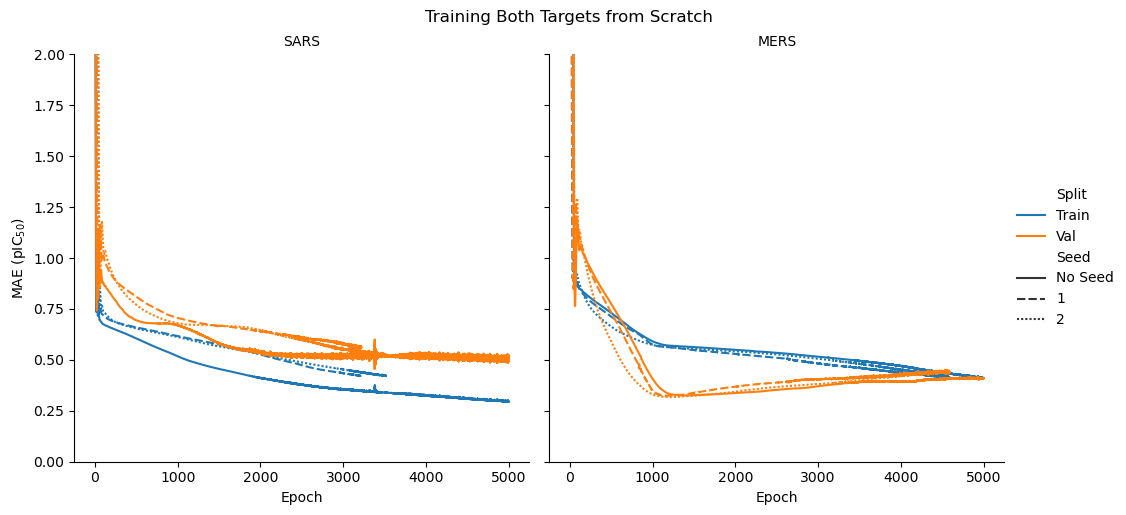

In [10]:
fg = sns.relplot(
    epoch_plot_df.loc[from_scratch_idx, :],
    x="epoch",
    y="MAE",
    col="Train Target",
    col_order=["SARS", "MERS"],
    style="Seed",
    style_order=["No Seed", "1", "2"],
    hue="Split",
    hue_order=["Train", "Val"],
    # dashes={"Train": "", "Val": (1, 4)},
    facet_kws={"sharex": False},
    kind="line",
)

fg.set(ylim=(0, 2))
fg.set_titles("{col_name}")
fg.set_axis_labels(y_var="MAE (pIC$_{50}$)", x_var="Epoch")
fg.figure.suptitle("Training Both Targets from Scratch", y=1.02)

fg.savefig("../figures/training_loss_curves.png", dpi=200, bbox_inches="tight")

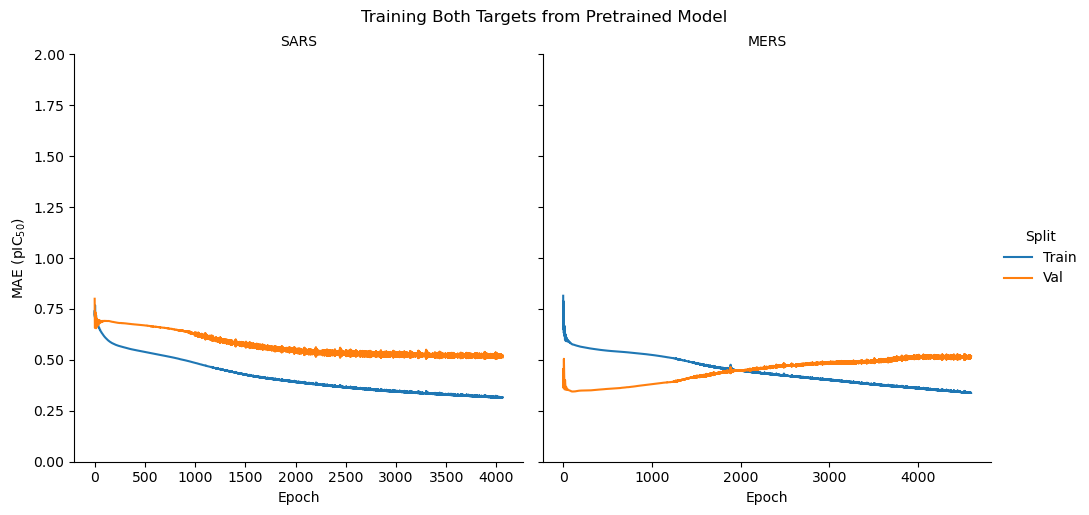

In [24]:
fg = sns.relplot(
    epoch_plot_df.loc[from_pretrained_idx, :],
    x="epoch",
    y="MAE",
    col="Train Target",
    col_order=["SARS", "MERS"],
    # style="Seed",
    # style_order=["No Seed", "1", "2"],
    hue="Split",
    hue_order=["Train", "Val"],
    # dashes={"Train": "", "Val": (1, 4)},
    facet_kws={"sharex": False},
    kind="line",
)

fg.set(ylim=(0, 2))
fg.set_titles("{col_name}")
fg.set_axis_labels(y_var="MAE (pIC$_{50}$)", x_var="Epoch")
fg.figure.suptitle("Training Both Targets from Pretrained Model", y=1.02)

fg.savefig("../figures/training_loss_curves_pretrained.png", dpi=200, bbox_inches="tight")

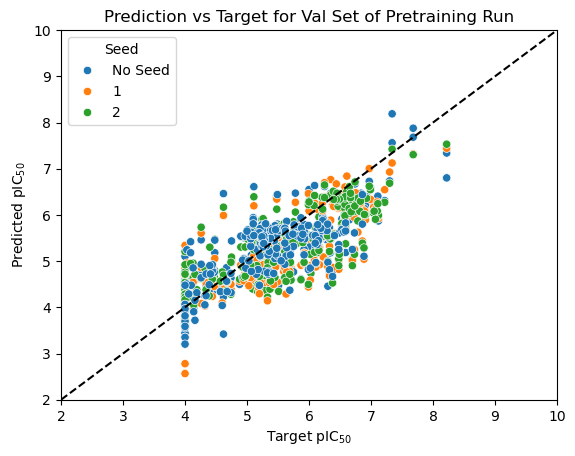

In [15]:
ax = sns.scatterplot(
    best_epoch_compound_df.loc[pretraining_idx & val_idx, :],
    x="target",
    y="pred",
    hue="Seed",
    hue_order=["No Seed", "1", "2"],
)

ax.set_xlim(2, 10)
ax.set_ylim(2, 10)
ax.plot([2, 10], [2, 10], ls="--", c="black")

ax.set_xlabel("Target pIC$_{50}$")
ax.set_ylabel("Predicted pIC$_{50}$")
ax.set_title("Prediction vs Target for Val Set of Pretraining Run")
ax.get_figure().savefig("../figures/pretraining_val_preds_best_loss.png", dpi=200, bbox_inches="tight")

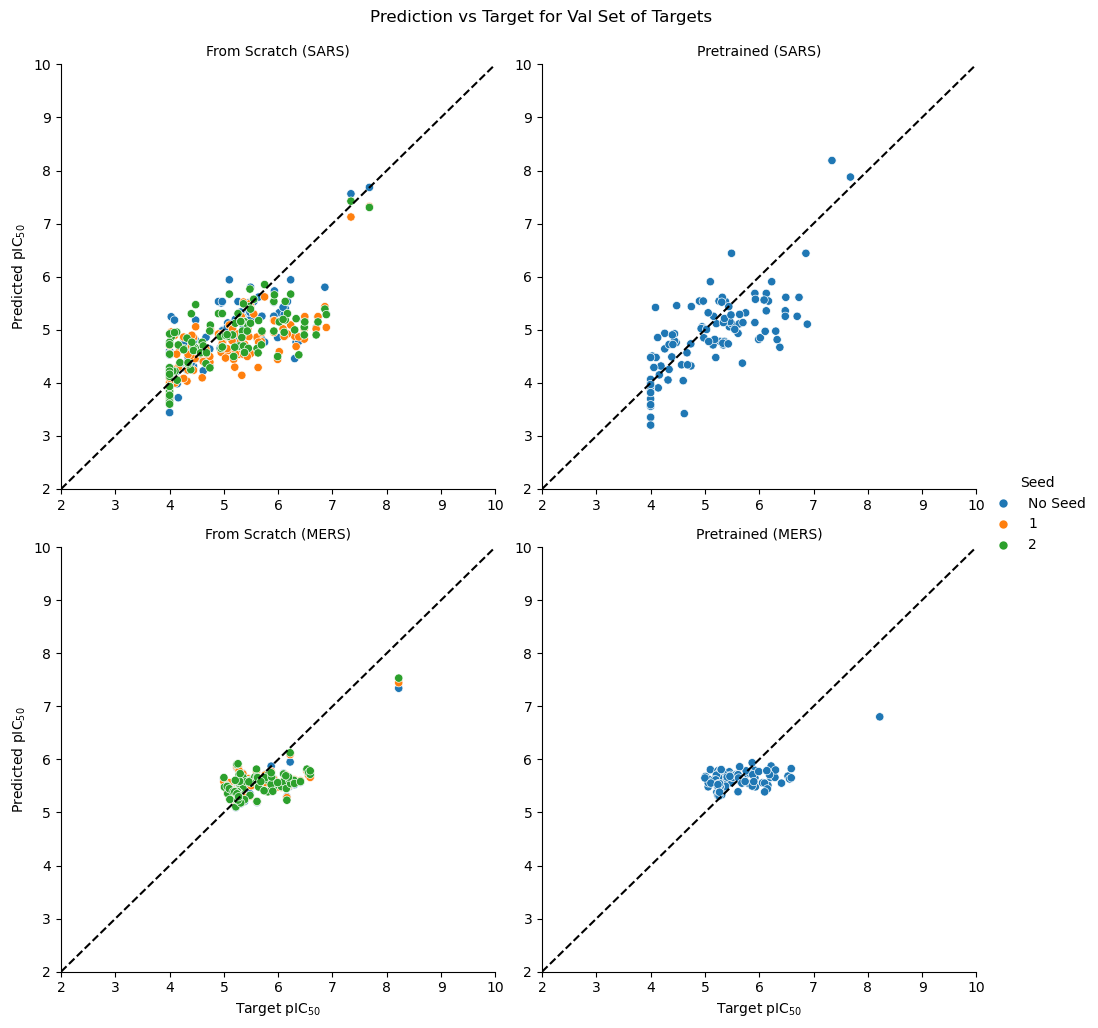

In [16]:
fg = sns.relplot(
    best_epoch_compound_df.loc[val_idx, :],
    x="target",
    y="pred",
    row="Train Target",
    row_order=["SARS", "MERS"],
    col="pretrained",
    col_order=["From Scratch", "Pretrained"],
    hue="Seed",
    hue_order=["No Seed", "1", "2"],
    facet_kws={"sharex": False, "sharey": False},
    kind="scatter",
)

fg.set(ylim=(2, 10), xlim=(2, 10))
for ax in fg.axes.ravel():
    ax.plot([2, 10], [2, 10], ls="--", c="black")
fg.set_titles("{col_name} ({row_name})")
fg.set_axis_labels(x_var="Target pIC$_{50}$", y_var="Predicted pIC$_{50}$")
fg.figure.suptitle("Prediction vs Target for Val Set of Targets", y=1.02)

fg.savefig("../figures/val_preds_best_loss_both.png", dpi=200, bbox_inches="tight")

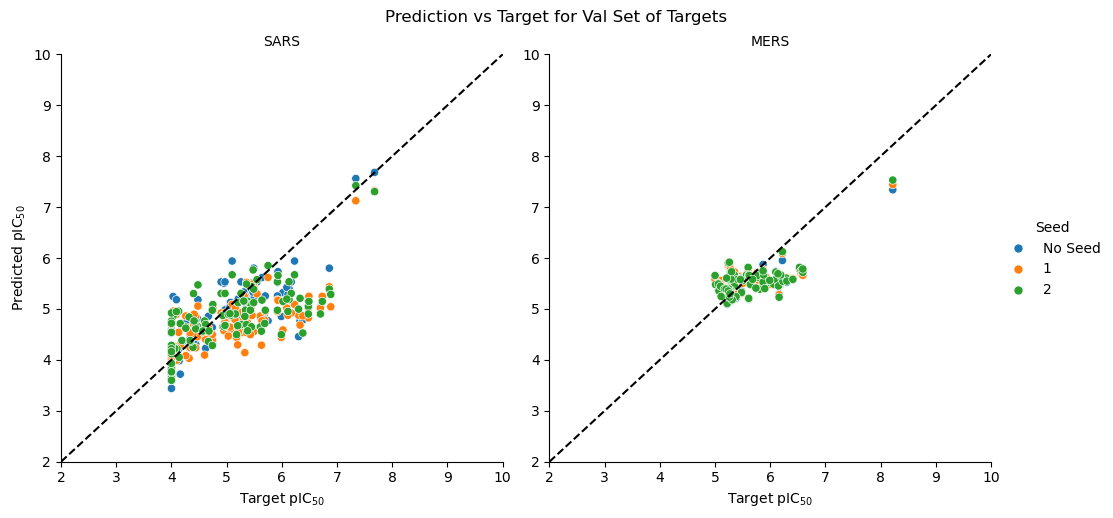

In [20]:
fg = sns.relplot(
    best_epoch_compound_df.loc[val_idx & best_epoch_from_scratch_idx, :],
    x="target",
    y="pred",
    col="Train Target",
    col_order=["SARS", "MERS"],
    hue="Seed",
    hue_order=["No Seed", "1", "2"],
    facet_kws={"sharex": False, "sharey": False},
    kind="scatter",
)

fg.set(ylim=(2, 10), xlim=(2, 10))
for ax in fg.axes.ravel():
    ax.plot([2, 10], [2, 10], ls="--", c="black")
fg.set_titles("{col_name}")
fg.set_axis_labels(x_var="Target pIC$_{50}$", y_var="Predicted pIC$_{50}$")
fg.figure.suptitle("Prediction vs Target for Val Set of Targets", y=1.02)

fg.savefig("../figures/val_preds_best_loss.png", dpi=200, bbox_inches="tight")

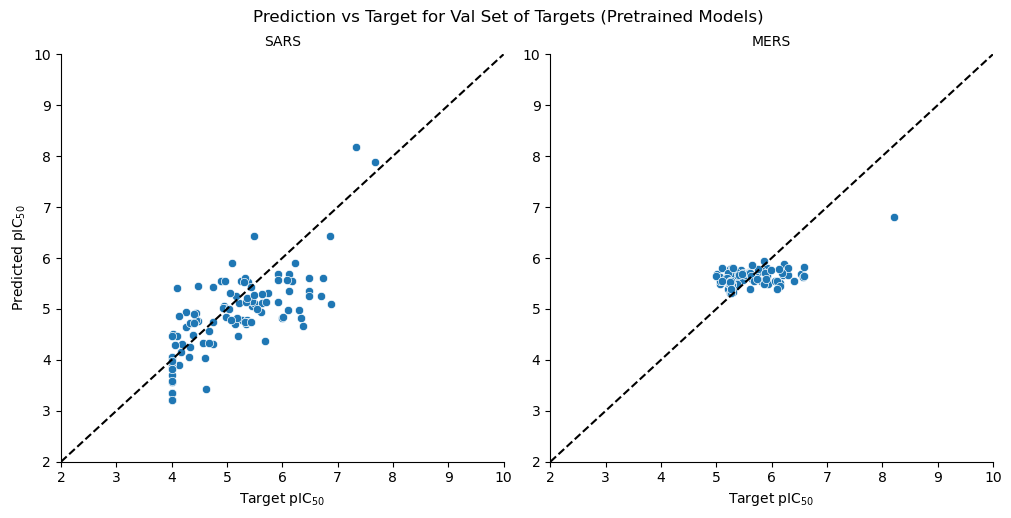

In [23]:
fg = sns.relplot(
    best_epoch_compound_df.loc[val_idx & best_epoch_from_pretrained_idx, :],
    x="target",
    y="pred",
    col="Train Target",
    col_order=["SARS", "MERS"],
    # hue="Seed",
    # hue_order=["No Seed", "1", "2"],
    facet_kws={"sharex": False, "sharey": False},
    kind="scatter",
)

fg.set(ylim=(2, 10), xlim=(2, 10))
for ax in fg.axes.ravel():
    ax.plot([2, 10], [2, 10], ls="--", c="black")
fg.set_titles("{col_name}")
fg.set_axis_labels(x_var="Target pIC$_{50}$", y_var="Predicted pIC$_{50}$")
fg.figure.suptitle(
    "Prediction vs Target for Val Set of Targets (Pretrained Models)", y=1.02
)

fg.savefig("../figures/val_preds_best_loss_pretrained.png", dpi=200, bbox_inches="tight")

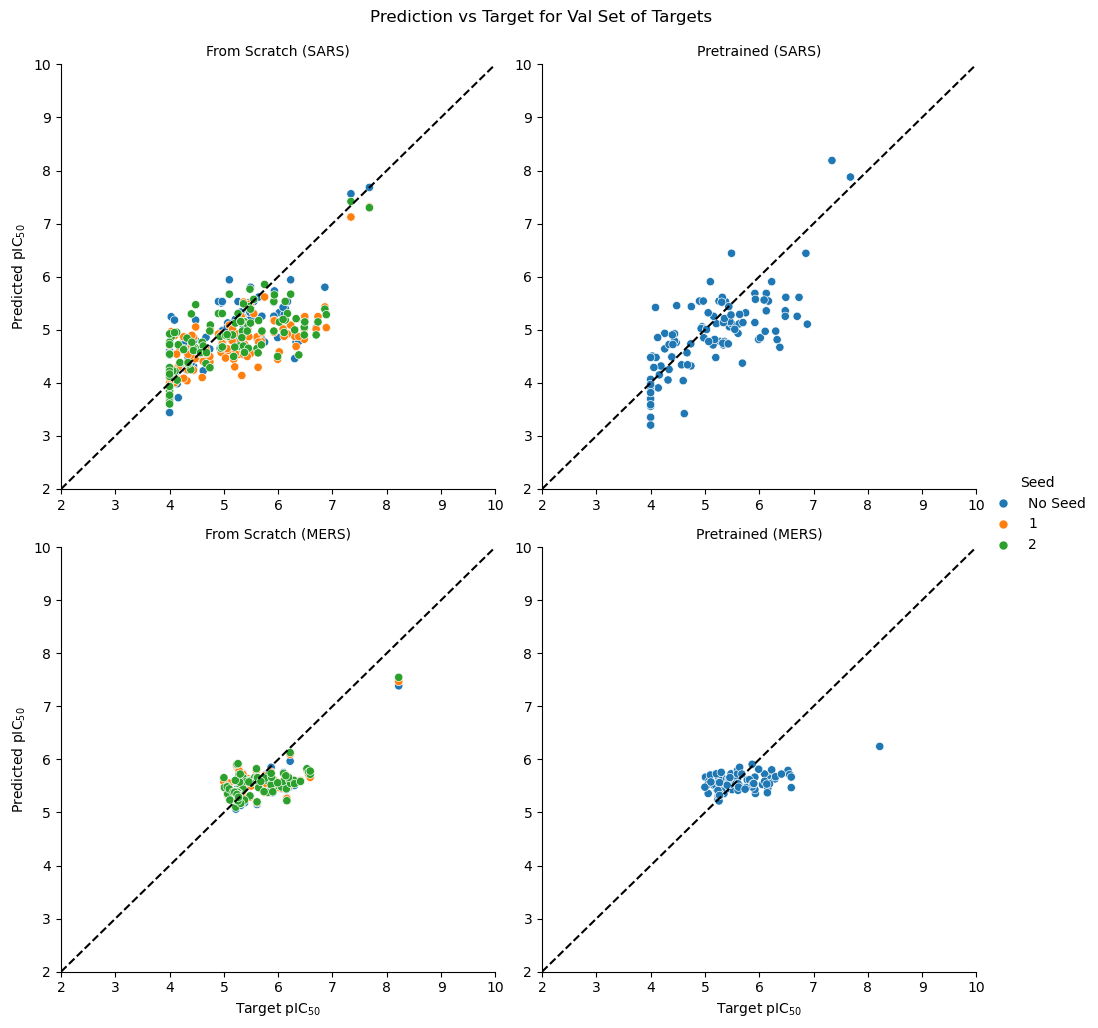

In [26]:
fg = sns.relplot(
    mae_best_epoch_compound_df.loc[mae_val_idx, :],
    x="target",
    y="pred",
    row="Train Target",
    row_order=["SARS", "MERS"],
    col="pretrained",
    col_order=["From Scratch", "Pretrained"],
    hue="Seed",
    hue_order=["No Seed", "1", "2"],
    facet_kws={"sharex": False, "sharey": False},
    kind="scatter",
)

fg.set(ylim=(2, 10), xlim=(2, 10))
for ax in fg.axes.ravel():
    ax.plot([2, 10], [2, 10], ls="--", c="black")
fg.set_titles("{col_name} ({row_name})")
fg.set_axis_labels(x_var="Target pIC$_{50}$", y_var="Predicted pIC$_{50}$")
fg.figure.suptitle("Prediction vs Target for Val Set of Targets", y=1.02)

fg.savefig("../figures/val_preds_best_mae_both.png", dpi=200, bbox_inches="tight")

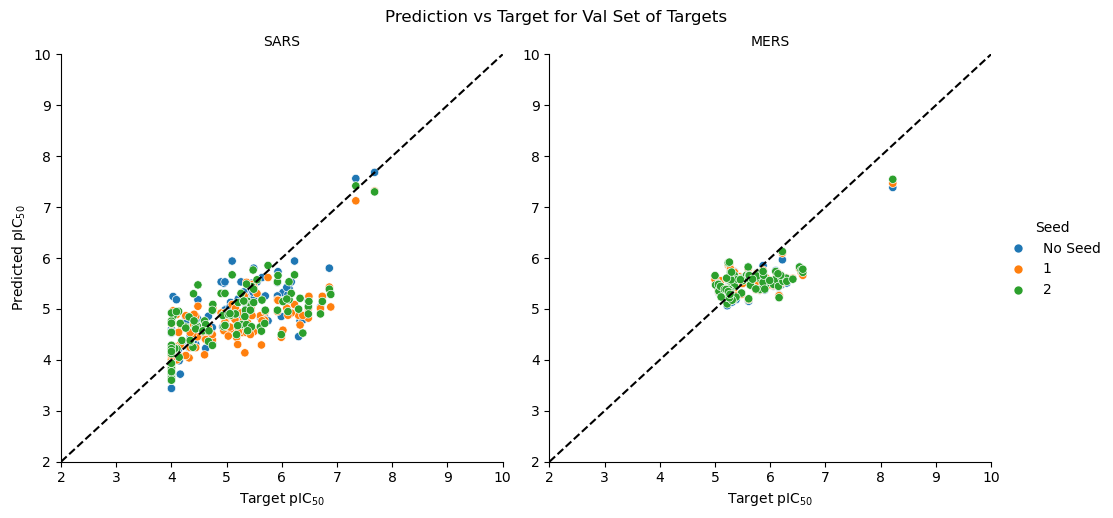

In [27]:
fg = sns.relplot(
    mae_best_epoch_compound_df.loc[mae_val_idx & mae_best_epoch_from_scratch_idx, :],
    x="target",
    y="pred",
    col="Train Target",
    col_order=["SARS", "MERS"],
    hue="Seed",
    hue_order=["No Seed", "1", "2"],
    facet_kws={"sharex": False, "sharey": False},
    kind="scatter",
)

fg.set(ylim=(2, 10), xlim=(2, 10))
for ax in fg.axes.ravel():
    ax.plot([2, 10], [2, 10], ls="--", c="black")
fg.set_titles("{col_name}")
fg.set_axis_labels(x_var="Target pIC$_{50}$", y_var="Predicted pIC$_{50}$")
fg.figure.suptitle("Prediction vs Target for Val Set of Targets", y=1.02)

fg.savefig("../figures/val_preds_best_mae.png", dpi=200, bbox_inches="tight")

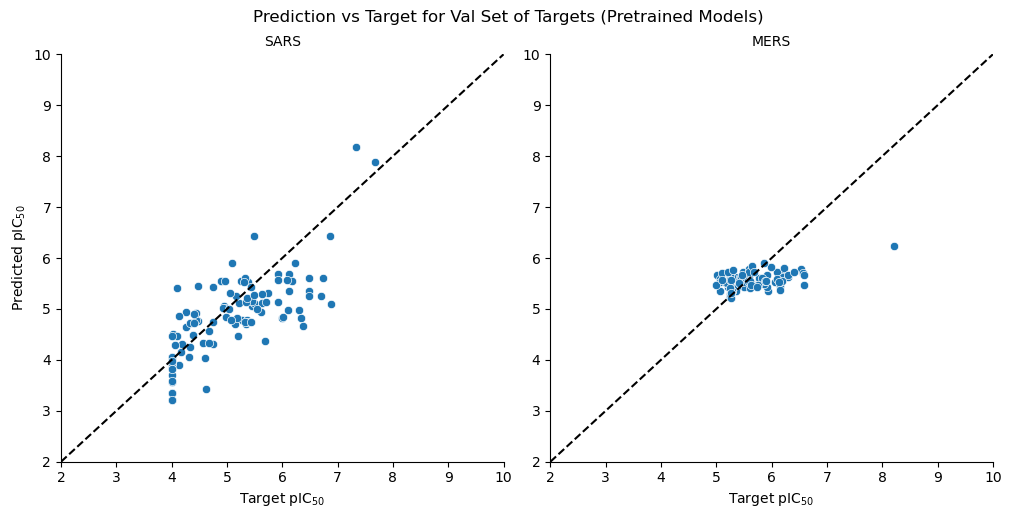

In [28]:
fg = sns.relplot(
    mae_best_epoch_compound_df.loc[mae_val_idx & mae_best_epoch_from_pretrained_idx, :],
    x="target",
    y="pred",
    col="Train Target",
    col_order=["SARS", "MERS"],
    # hue="Seed",
    # hue_order=["No Seed", "1", "2"],
    facet_kws={"sharex": False, "sharey": False},
    kind="scatter",
)

fg.set(ylim=(2, 10), xlim=(2, 10))
for ax in fg.axes.ravel():
    ax.plot([2, 10], [2, 10], ls="--", c="black")
fg.set_titles("{col_name}")
fg.set_axis_labels(x_var="Target pIC$_{50}$", y_var="Predicted pIC$_{50}$")
fg.figure.suptitle(
    "Prediction vs Target for Val Set of Targets (Pretrained Models)", y=1.02
)

fg.savefig("../figures/val_preds_best_mae_pretrained.png", dpi=200, bbox_inches="tight")